In [ ]:
%%capture
!pip install --upgrade -q flax

In [ ]:
# Run it on a TPU (if possible)!
import jax.tools.colab_tpu
try:
  jax.tools.colab_tpu.setup_tpu()
except:
  pass

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from functools import partial
import jax
import jax.numpy as jnp
from typing import Any, Tuple

PRNGKey = jnp.ndarray

num_devices = jax.device_count()

args = {
    'z_dim': 128, #256 is way too many
    'seed': 41,
}

# Set the parallel batch size.
num = 200

args['batch_size'] = num_devices * num if num_devices > 1 else num
args['epochs'] = 100
args['batch_size_p'] = args['batch_size'] //  num_devices

args['true_label'] = jnp.ones((args['batch_size_p'], 1), dtype=jnp.int32)
args['false_label'] = jnp.zeros((args['batch_size_p'], 1), dtype=jnp.int32)

os.makedirs(os.path.join("results", "1_GAN"), exist_ok=True)

## Loading Data

In [ ]:
from PIL import Image
from os import listdir
from os.path import isfile, join
import numpy as np
import itertools

absolute = "drive/MyDrive/project/small/"
images = []
paths = [str(i) for i in range(30)]
for p in paths:
  path = absolute + p
  files = [f for f in listdir(path) if isfile(join(path + "/", f))]
  for file in files:
    im = Image.open(path + "/" + file)
    arr = np.asarray(im)
    dims = [1] + list(arr.shape)
    arr = np.reshape(arr, tuple(dims))
    images += [arr]

images = np.concatenate(images, axis=0)
bs = args['batch_size']
batches_in_epoch = images.shape[0] // bs
print(images.shape)

(30000, 28, 28)


In [ ]:
set_range = lambda im: (im - 0.5) / 0.5  # tanh range is -1, 1
j = lambda data: jnp.asarray(data)

def generate_iter():
  im = set_range(np.copy(images))
  im = np.reshape(im, (images.shape[0], images.shape[1], images.shape[2], 1) )
  im = np.random.permutation(im)
  l = [ j(im[i * bs: (i + 1) * bs]) for i in range(batches_in_epoch) ]
  return iter(l)

data_gen = generate_iter()


## Flax Linen Architecture

In [ ]:
from jax.nn.initializers import normal as normal_init
from flax.training import train_state
from flax import linen as nn


class TrainState(train_state.TrainState):
  batch_stats: Any


class Generator(nn.Module):
  features: int = args['z_dim']
  dtype: type = jnp.float32

  @nn.compact
  def __call__(self, z: jnp.ndarray, train: bool = True):
    conv_transpose = partial(nn.ConvTranspose, padding='VALID',
                             kernel_init=normal_init(0.02), dtype=self.dtype)
    batch_norm = partial(nn.BatchNorm, use_running_average=not train, axis=-1,
                         scale_init=normal_init(0.02), dtype=self.dtype)

    z = z.reshape((args['batch_size_p'], 1, 1, args['z_dim']))
    print(z.shape)
    x = conv_transpose(self.features*4, kernel_size=[3, 3], strides=[2, 2])(z)
    print(x.shape)
    x = batch_norm()(x)
    x = nn.relu(x)
    x = conv_transpose(self.features*4, kernel_size=[4, 4], strides=[1, 1])(x)
    print(x.shape)
    x = batch_norm()(x)
    x = nn.relu(x)
    x = conv_transpose(self.features*2, kernel_size=[3, 3], strides=[2, 2])(x)
    print(x.shape)
    x = batch_norm()(x)
    x = nn.relu(x)
    x = conv_transpose(1, kernel_size=[4, 4], strides=[2, 2])(x)
    x = jnp.tanh(x)
    return x


class Discriminator(nn.Module):
  features: int = args['z_dim']
  dtype: Any = jnp.float32

  @nn.compact
  def __call__(self, x: jnp.ndarray, train: bool = True):
    conv = partial(nn.Conv, kernel_size=[4, 4], strides=[2, 2], padding='VALID',
                   kernel_init=normal_init(0.02), dtype=self.dtype)
    batch_norm = partial(nn.BatchNorm, use_running_average=not train, axis=-1,
                         scale_init=normal_init(0.02), dtype=self.dtype)

    print(x.shape)
    x = conv(self.features)(x)
    print(x.shape)
    x = batch_norm()(x)
    x = nn.leaky_relu(x, 0.2)
    x = conv(self.features*2)(x)
    print(x.shape)
    x = batch_norm()(x)
    x = nn.leaky_relu(x, 0.2)
    x = conv(1)(x)
    print(x.shape)
    x = x.reshape((args['batch_size_p'], -1))
    return x

## GAN Loss Function

In [ ]:
import optax

@partial(jax.pmap, axis_name='num_devices')
def generator_step(generator_state: TrainState,
                   discriminator_state: TrainState,
                   key: PRNGKey):
  r"""The generator is updated by generating data and letting the discriminator
  critique it. It's loss goes down if the discriminator wrongly predicts it to
  to be real data."""
  input_noise = jax.random.normal(key, (args['batch_size_p'], args['z_dim']))

  def loss_fn(params):
    generated_data, mutables = generator_state.apply_fn(
        {'params': params, 'batch_stats': generator_state.batch_stats},
        input_noise, mutable=['batch_stats'])

    logits, _ = discriminator_state.apply_fn(
        {'params': discriminator_state.params,
         'batch_stats': discriminator_state.batch_stats},
         generated_data, mutable=['batch_stats'])

    """
    TODO: CALCULATE GENERATOR LOSS
    HINT: USE jnp.mean(*args), jnp.log(*args), and nn.sigmoid(*args)
    HINT: THINK ABOUT IF THE LOSS SHOULD BE NEGATIVE OR POSITIVE
    NOTE: Minimizing cross entropy is equivalent to minimizing KL Divergence
    """
    loss = -jnp.mean(jnp.log(nn.sigmoid(logits))) #TODO
    return loss, mutables

  # Generate data with the Generator, critique it with the Discriminator.
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, mutables), grads = grad_fn(generator_state.params)

  # Average across the devices.
  grads = jax.lax.pmean(grads, axis_name='num_devices')
  loss = jax.lax.pmean(loss, axis_name='num_devices')

  # Update the Generator through gradient descent.
  new_generator_state = generator_state.apply_gradients(
      grads=grads, batch_stats=mutables['batch_stats'])

  return new_generator_state, loss


@partial(jax.pmap, axis_name='num_devices')
def discriminator_step(generator_state: TrainState,
                       discriminator_state: TrainState,
                       real_data: jnp.ndarray,
                       key: PRNGKey):
  r"""The discriminator is updated by critiquing both real and generated data,
  It's loss goes down as it predicts correctly if images are real or generated.
  """
  input_noise = jax.random.normal(key, (args['batch_size_p'], args['z_dim']))

  generated_data, _ = generator_state.apply_fn(
        {'params': generator_state.params,
         'batch_stats': generator_state.batch_stats},
         input_noise, mutable=['batch_stats'])

  def loss_fn(params):
    logits_real, mutables = discriminator_state.apply_fn(
        {'params': params, 'batch_stats': discriminator_state.batch_stats},
        real_data, mutable=['batch_stats'])

    logits_generated, mutables = discriminator_state.apply_fn(
        {'params': params, 'batch_stats': mutables['batch_stats']},
        generated_data, mutable=['batch_stats'])

    """
    TODO: CALCULATE REAL LOSS, GENERATED LOSS, AND AVG
    HINT: USE optax.sigmoid_binary_cross_entropy(*args)
    HINT: USE args['true_label'] and args['false_label']
    HINT: THINK ABOUT IF THE LOSS SHOULD BE NEGATIVE OR POSITIVE
    NOTE: Minimizing cross entropy is equivalent to minimizing KL Divergence
    """
    real_loss = optax.sigmoid_binary_cross_entropy(
        logits_real, args['true_label']).mean() #TODO
    generated_loss = optax.sigmoid_binary_cross_entropy(
        logits_generated, args['false_label']).mean() #TODO
    loss = (real_loss + generated_loss) / 2 #TODO

    return loss, mutables

  # Critique real and generated data with the Discriminator.
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, mutables), grads = grad_fn(discriminator_state.params)

  # Average cross the devices.
  grads = jax.lax.pmean(grads, axis_name='num_devices')
  loss = jax.lax.pmean(loss, axis_name='num_devices')

  """
    TODO: UPDATE THE DISCRIMINATOR THROUGH GRADIENT DESCENT
    HINT: USE TrainState.apply_gradients(*args)
  """
  new_discriminator_state = discriminator_state.apply_gradients(
      grads=grads, batch_stats=mutables['batch_stats']) #TODO

  return new_discriminator_state, loss

## Helper Functions

In [ ]:
@partial(jax.pmap, static_broadcasted_argnums=(1, 2))
def create_state(rng, model_cls, input_shape):
  r"""Create the training state given a model class. """
  model = model_cls()

  tx = optax.adam(0.0002, b1=0.5, b2=0.999)
  variables = model.init(rng, jnp.ones(input_shape))

  state = TrainState.create(apply_fn=model.apply, tx=tx,
      params=variables['params'], batch_stats=variables['batch_stats'])

  return state


@jax.pmap
def sample_from_generator(generator_state, input_noise):
  """Sample from the generator in evaluation mode."""
  generated_data = generator_state.apply_fn(
      {'params': generator_state.params,
       'batch_stats': generator_state.batch_stats},
      input_noise, train=False, mutable=False)
  return generated_data

## Training

In [ ]:
from flax.training.common_utils import shard, shard_prng_key


key = jax.random.PRNGKey(seed=args['seed'])
key_generator, key_discriminator, key = jax.random.split(key, 3)
key_generator = shard_prng_key(key_generator)
key_discriminator = shard_prng_key(key_discriminator)

discriminator_state = create_state(key_discriminator, Discriminator,
    (args['batch_size_p'], *next(data_gen).shape[1:]))

generator_state = create_state(key_generator, Generator,
    (args['batch_size_p'], args['z_dim']))

generator_input = jax.random.normal(key, (args['batch_size'], args['z_dim']))
generator_input = shard(generator_input)

(200, 28, 28, 1)
(200, 13, 13, 128)
(200, 5, 5, 256)
(200, 1, 1, 1)
(200, 1, 1, 128)
(200, 3, 3, 512)
(200, 6, 6, 512)
(200, 13, 13, 256)


In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


for epoch in tqdm(range(1, args['epochs'] + 1), desc="Epoch...",
                  position=0, leave=True):

  with tqdm(total=batches_in_epoch, desc="Training...",
            leave=False) as progress_bar_train:
    for batch in range(batches_in_epoch):

      # Generate RNG keys for generator and discriminator.
      key, key_generator, key_discriminator = jax.random.split(key, 3)
      key_generator = shard_prng_key(key_generator)
      key_discriminator = shard_prng_key(key_discriminator)

      # Shard the data to possible devices.
      nxt = next(data_gen, None)
      if nxt == None:
        data_gen = generate_iter()
        nxt = next(data_gen)
      batch_data = shard(nxt)

      """
      TODO: TAKE A STEP WITH GENERATOR AND DISCRIMINATOR
      """
      generator_state, generator_loss = generator_step(generator_state,
          discriminator_state, key_generator) #TODO

      discriminator_state, discriminator_loss = discriminator_step(
          generator_state, discriminator_state, batch_data, key_discriminator) #TODO

      progress_bar_train.update(1)

    metrics = jax.device_get([generator_loss[0], discriminator_loss[1]])

    message = f"Epoch: {epoch: <2} | "
    message += f"Generator loss: {metrics[0]:.3f} | "
    message += f"Discriminator loss: {metrics[1]:.3f}"
    progress_bar_train.write(message)

  # Sample from the generator using the fixed input. We need to
  # reshape if we are working on multiple devices.
  sample = sample_from_generator(generator_state, generator_input)
  sample = sample.reshape((-1, 28, 28))

  # Next, plot the static samples, save the fig to disk.
  if epoch % 10 == 0:
    fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
    for ax, image in zip(sum(axes.tolist(), []), sample):
      ax.imshow(image, cmap='gray')
      ax.set_axis_off()
    fig.savefig(f"results/1_GAN/GAN_epoch_{epoch}.png")
    plt.close(fig)

Epoch...:   0%|          | 0/100 [00:00<?, ?it/s]

Training...:   0%|          | 0/150 [00:00<?, ?it/s]

(200, 1, 1, 128)
(200, 3, 3, 512)
(200, 6, 6, 512)
(200, 13, 13, 256)
(200, 28, 28, 1)
(200, 13, 13, 128)
(200, 5, 5, 256)
(200, 1, 1, 1)
(200, 1, 1, 128)
(200, 3, 3, 512)
(200, 6, 6, 512)
(200, 13, 13, 256)
(200, 28, 28, 1)
(200, 13, 13, 128)
(200, 5, 5, 256)
(200, 1, 1, 1)
(200, 28, 28, 1)
(200, 13, 13, 128)
(200, 5, 5, 256)
(200, 1, 1, 1)
Epoch: 1  | Generator loss: 1.299 | Discriminator loss: 0.341
(200, 1, 1, 128)
(200, 3, 3, 512)
(200, 6, 6, 512)
(200, 13, 13, 256)


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 2  | Generator loss: 2.479 | Discriminator loss: 0.125


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 3  | Generator loss: 2.924 | Discriminator loss: 0.078


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 4  | Generator loss: 3.440 | Discriminator loss: 0.070


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 5  | Generator loss: 1.986 | Discriminator loss: 0.485


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 6  | Generator loss: 1.501 | Discriminator loss: 0.509


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 7  | Generator loss: 2.818 | Discriminator loss: 0.193


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 8  | Generator loss: 1.288 | Discriminator loss: 0.529


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 9  | Generator loss: 2.114 | Discriminator loss: 0.236


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 10 | Generator loss: 2.860 | Discriminator loss: 0.135


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 11 | Generator loss: 4.317 | Discriminator loss: 0.054


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 12 | Generator loss: 4.154 | Discriminator loss: 0.057


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 13 | Generator loss: 4.056 | Discriminator loss: 0.045


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 14 | Generator loss: 3.389 | Discriminator loss: 0.298


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 15 | Generator loss: 1.523 | Discriminator loss: 0.418


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 16 | Generator loss: 1.669 | Discriminator loss: 0.385


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 17 | Generator loss: 1.334 | Discriminator loss: 0.495


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 18 | Generator loss: 1.493 | Discriminator loss: 0.418


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 19 | Generator loss: 3.114 | Discriminator loss: 0.134


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 20 | Generator loss: 1.299 | Discriminator loss: 0.431


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 21 | Generator loss: 1.046 | Discriminator loss: 0.546


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 22 | Generator loss: 3.490 | Discriminator loss: 0.144


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 23 | Generator loss: 1.949 | Discriminator loss: 0.684


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 24 | Generator loss: 1.675 | Discriminator loss: 0.371


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 25 | Generator loss: 3.467 | Discriminator loss: 0.066


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 26 | Generator loss: 4.419 | Discriminator loss: 0.059


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 27 | Generator loss: 4.841 | Discriminator loss: 0.072


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 28 | Generator loss: 5.048 | Discriminator loss: 0.033


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 29 | Generator loss: 3.772 | Discriminator loss: 0.338


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 30 | Generator loss: 3.852 | Discriminator loss: 0.072


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 31 | Generator loss: 3.736 | Discriminator loss: 0.226


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 32 | Generator loss: 1.353 | Discriminator loss: 0.536


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 33 | Generator loss: 1.088 | Discriminator loss: 0.620


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 34 | Generator loss: 1.222 | Discriminator loss: 0.597


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 35 | Generator loss: 1.360 | Discriminator loss: 0.569


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 36 | Generator loss: 1.344 | Discriminator loss: 0.560


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 37 | Generator loss: 1.164 | Discriminator loss: 0.569


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 38 | Generator loss: 3.223 | Discriminator loss: 0.085


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 39 | Generator loss: 2.922 | Discriminator loss: 0.212


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 40 | Generator loss: 3.565 | Discriminator loss: 0.106


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 41 | Generator loss: 4.175 | Discriminator loss: 0.045


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 42 | Generator loss: 5.212 | Discriminator loss: 0.047


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 43 | Generator loss: 3.749 | Discriminator loss: 0.093


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 44 | Generator loss: 4.055 | Discriminator loss: 0.060


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 45 | Generator loss: 2.221 | Discriminator loss: 0.398


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 46 | Generator loss: 3.833 | Discriminator loss: 0.555


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 47 | Generator loss: 3.195 | Discriminator loss: 0.067


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 48 | Generator loss: 4.241 | Discriminator loss: 0.033


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 49 | Generator loss: 4.732 | Discriminator loss: 0.060


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 50 | Generator loss: 4.321 | Discriminator loss: 0.137


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 51 | Generator loss: 4.821 | Discriminator loss: 0.154


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 52 | Generator loss: 1.725 | Discriminator loss: 0.424


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 53 | Generator loss: 1.708 | Discriminator loss: 0.501


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 54 | Generator loss: 1.314 | Discriminator loss: 0.502


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 55 | Generator loss: 2.942 | Discriminator loss: 0.110


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 56 | Generator loss: 3.774 | Discriminator loss: 0.061


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 57 | Generator loss: 2.972 | Discriminator loss: 0.297


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 58 | Generator loss: 4.177 | Discriminator loss: 0.061


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 59 | Generator loss: 4.804 | Discriminator loss: 0.041


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 60 | Generator loss: 3.862 | Discriminator loss: 0.191


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 61 | Generator loss: 4.430 | Discriminator loss: 0.043


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 62 | Generator loss: 4.638 | Discriminator loss: 0.065


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 63 | Generator loss: 5.074 | Discriminator loss: 0.064


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 64 | Generator loss: 4.085 | Discriminator loss: 0.114


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 65 | Generator loss: 2.277 | Discriminator loss: 0.317


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 66 | Generator loss: 1.886 | Discriminator loss: 0.406


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 67 | Generator loss: 1.715 | Discriminator loss: 0.363


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 68 | Generator loss: 3.253 | Discriminator loss: 0.582


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 69 | Generator loss: 1.311 | Discriminator loss: 0.666


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 70 | Generator loss: 2.871 | Discriminator loss: 0.134


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 71 | Generator loss: 4.207 | Discriminator loss: 0.084


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 72 | Generator loss: 3.564 | Discriminator loss: 0.162


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 73 | Generator loss: 3.998 | Discriminator loss: 0.422


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 74 | Generator loss: 2.840 | Discriminator loss: 0.124


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 75 | Generator loss: 3.888 | Discriminator loss: 0.056


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 76 | Generator loss: 4.355 | Discriminator loss: 0.108


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 77 | Generator loss: 3.495 | Discriminator loss: 0.103


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 78 | Generator loss: 4.701 | Discriminator loss: 0.024


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 79 | Generator loss: 4.748 | Discriminator loss: 0.061


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 80 | Generator loss: 5.097 | Discriminator loss: 0.032


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 81 | Generator loss: 4.138 | Discriminator loss: 0.243


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 82 | Generator loss: 3.696 | Discriminator loss: 0.105


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 83 | Generator loss: 3.226 | Discriminator loss: 0.229


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 84 | Generator loss: 3.479 | Discriminator loss: 0.134


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 85 | Generator loss: 5.382 | Discriminator loss: 0.040


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 86 | Generator loss: 4.298 | Discriminator loss: 0.039


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 87 | Generator loss: 5.692 | Discriminator loss: 0.030


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 88 | Generator loss: 5.438 | Discriminator loss: 0.031


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 89 | Generator loss: 5.089 | Discriminator loss: 0.037


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 90 | Generator loss: 4.116 | Discriminator loss: 0.212


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 91 | Generator loss: 5.302 | Discriminator loss: 0.075


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 92 | Generator loss: 4.971 | Discriminator loss: 0.034


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 93 | Generator loss: 4.201 | Discriminator loss: 0.136


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 94 | Generator loss: 5.726 | Discriminator loss: 0.035


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 95 | Generator loss: 5.276 | Discriminator loss: 0.057


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 96 | Generator loss: 2.562 | Discriminator loss: 0.305


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 97 | Generator loss: 1.868 | Discriminator loss: 0.395


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 98 | Generator loss: 1.708 | Discriminator loss: 0.453


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 99 | Generator loss: 3.005 | Discriminator loss: 0.317


Training...:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 100 | Generator loss: 1.677 | Discriminator loss: 0.384


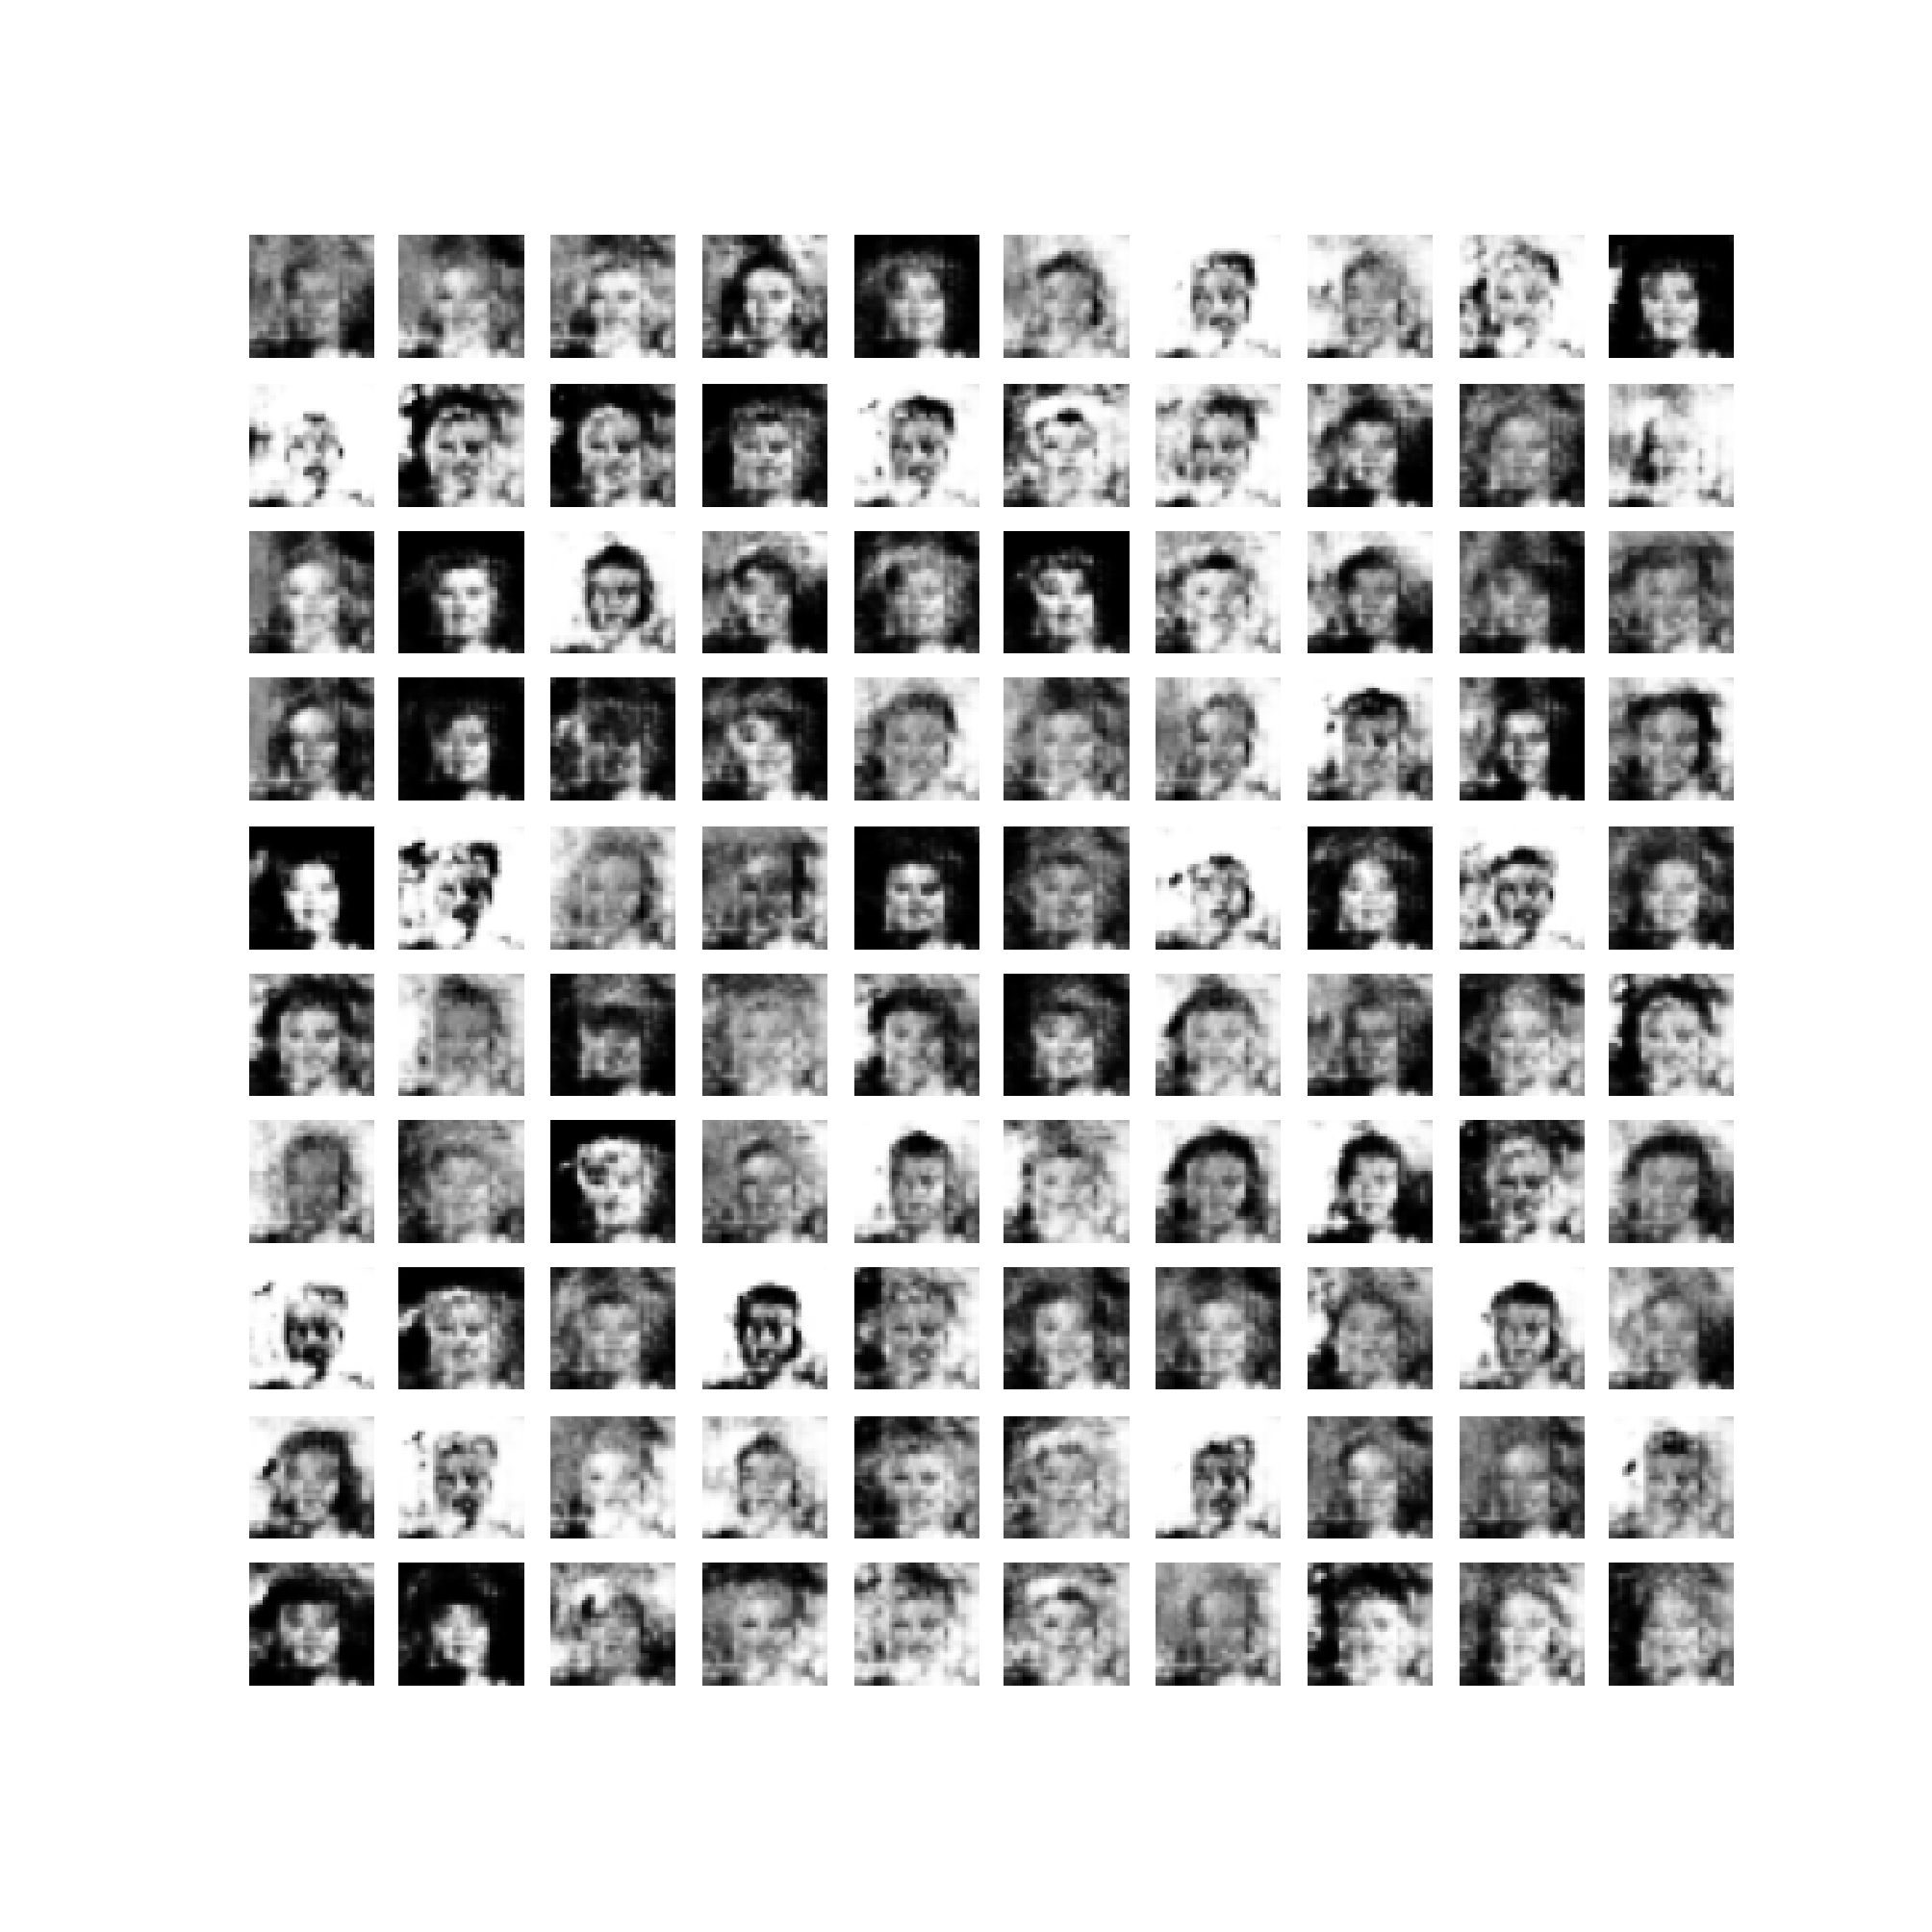

In [ ]:
import matplotlib.image as mpimg

# Load latest epoch results.
img = mpimg.imread(os.path.join('results', '1_GAN', f'GAN_epoch_{epoch}.png'))


fig, ax = plt.subplots(figsize=(28, 28))
ax.imshow(img, interpolation='nearest')
plt.axis('off')
plt.tight_layout()
plt.show()

Note: There might be errors with convergence as theree are issues that are present in GANS. Label smoothing, batch-norm, tweaking the generator loss function, or just re-running could help with this.